In [1]:
import midus_varsum as mvs
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<a id="intro"></a>
# Introduction

After playing around with the <a href="http://midus.wisc.edu/" target="_blank">MIDUS</a> XML file during my <a href="https://alexdatasci.com/a-little-bit-of-xml-and-python/" target="_blank">last post</a>, I ended up falling down a bit of a rabbit hole trying to figure out the best way to wrangle the information related to the variables available in the MIDUS 1 dataset. My initial goal seemed simple enough: to be able to find variable names by a search string, matched to the variable label, scale, or topic. In terms of the variable label, this proved simple enough; however, the XML file (as far as I could tell) did not have information related to scales or topics. That information _was_ in a pdf that comes with that data. Then I foolishly decided to try to parse the pdf text to extract what I wanted. I knew that it would probably be tedious and time consuming, but just couldn't help myself. Well, I was right. It was tedious and time consuming. I didn't get everything I wanted before I decided I couldn't spend any more time on it, but I did come away with some useful tools. I haven't made a post about it (at least not yet), but the python file that has everything I did (which I'll use here as well, see 'midus_varsum') is on GITHUB_ADDLINK. 

Anyway, the main reason I wanted to be able to get so much information about the individual variables in the first place was to try out this support vector machine project:

__The Scenario__

Let's say that someone has a ton of questionnaire data that assesses a lot of different aspects of life for middle aged people (e.g. subjective mental/physical health, family obligations, social support, etc.) as well as objective measures of physical health (e.g. blood pressure, disease, etc.). Given all that information, can we create a tool that uses a reasonable subset of all those measures (say 10-20 out of a couple thousand or so) that can do a decent job of discriminating between those at risk for a particular physical disease or condition? Moreover, can we do that using variables that are not themselves direct proxies for that particular disease or condition? That's what I'll attempt to do here, with the binary high/low blood pressure variable as the outcome variable of interest.

__The Data__

I'll use data from the MIDUS 1 study. The data is publicly available (you have to register and agree to terms of use before downloading) and hosted at <a href="https://www.icpsr.umich.edu/icpsrweb/ICPSR/studies/2760/variables" target="_blank">ICPSR</a>. The reference is listed below:

Brim, Orville G., Baltes, Paul B., Bumpass, Larry L., Cleary, Paul D., Featherman, David L., Hazzard, William R., … Shweder, Richard A. Midlife in the United States (MIDUS 1), 1995-1996. Ann Arbor, MI: Inter-university Consortium for Political and Social Research [distributor], 2017-11-16. https://doi.org/10.3886/ICPSR02760.v12

__The Variables__

The goal here is to predict high/low BP based on a reasonable number of _individual_ items. This means I don't want to include fully-constructed scales. I'll put my XML/PDF parsing efforts to work to help with that. I also want to make sure to avoid including predictor variables that that are too synonymous with the outcome variable. For example, a variable that indicates whether someone has heart failure or is on a beta-blocker is probably very predictive, but doesn't really match our goals.

__Dealing with a large(ish) dataset.__

Most of the research I do in my lab doesn't involve massive datasets. They're usually limited to a few hundred observations at most, with anywhere from 20 to ~1000 variables. Although it's not "big data" huge, it is big enough (36 MB, 7,000+ observations, ~2,000 variables) that you notice the lag if you try to load it all at once. This isn't a big deal, but I'll still try to figure out what I need first, then load what's required only, instead of loading everything at once. 

<a id="analysis"></a>
# Analysis Plan

* Explore variables
* Subset/clean data
  * Variables of interest
  * Deal with missing, etc.
  * Make training, validation, test sets
* Train classifier
  * Tune C parameter (regularization)
* Validate number of predictors
  * Balance Type I/II errors against # of predictors
* Test model

__Explore Variables__

First, let's figure out which DV to use. I'll use a little function I wrote that searches variable labels to find those related to blood pressure ('pressure' or 'bp'):

In [2]:
mvs.labsearch('pressure').append(mvs.labsearch('bp'),ignore_index=True)

,Variable,Topic,Description,Question
0,A1PA11BC,Health,High blood pressure,What was the diagnosis - HIGH BLOOD PRESSURE?
1,A1PA29CC,Health,High blood pressure,What did the doctor say it was - HIGH BLOOD PR...
2,A1PA33,Health,Taking Rx meds for blood pressure,Are you taking any prescription medications fo...
3,A1PA32S,Health,Blood pressure reading high,"What was the exact reading, if you remember - ..."
4,A1PA32D,Health,Blood pressure reading low,"What was the exact reading, if you remember - ..."
5,A1SA9S,Your Health,High blood pressure,"In the past twelve months, have you experience..."
6,A1PA34,Health,Other treatments for BP,(Not including prescription medications) Are y...
7,A1PA30,Health,# of Months since last BP test,How long has it been since your last blood pre...
8,A1PA31,Health,General results of BP test,"At that time, was your blood pressure low, abo..."


In [3]:
mvs.labsearch('pressure').append(mvs.labsearch('bp'),ignore_index=True)['Question'][4]

'What was the exact reading, if you remember - DIASTOLIC?'

A few variables adddress high blood pressure. We'll have to take a closer look to see which one is best.

In [4]:
bp_vars = mvs.labsearch('pressure').append(mvs.labsearch('bp'),ignore_index=True)['Variable']
tpath = '/Users/alex/Documents/alexdatasci/data_files/MIDUS_1/ICPSR_02760' \
    + '/DS0001/02760-0001-Data.dta'
bp_df = pd.read_stata(tpath,columns=bp_vars)
bp_df.head()

,A1PA11BC,A1PA29CC,A1PA33,A1PA32S,A1PA32D,A1SA9S,A1PA34,A1PA30,A1PA31
0,INAPP,INAPP,YES,120,70,NO,NO,2,SLIGHTLY RAISED
1,INAPP,INAPP,NO,DONT KNOW,DONT KNOW,NaN,NO,36,ABOUT NORMAL
2,INAPP,INAPP,NO,144,84,NO,NO,LESS THAN 1 MONTH,ABOUT NORMAL
3,INAPP,INAPP,YES,DONT KNOW,DONT KNOW,YES,YES,1,ABOUT NORMAL
4,INAPP,INAPP,NO,140,90,YES,NO,LESS THAN 1 MONTH,SLIGHTLY RAISED


I can already tell that some of these variables aren't gonna work. Let's see which of these variables is complete (or close to it). First, which variables have a lot of 'INAPP' (meaning not answered)?

In [5]:
bp_df.apply(lambda x: sum(x=='INAPP'))

A1PA11BC    6192
A1PA29CC    6700
A1PA33         0
A1PA32S       86
A1PA32D       86
A1SA9S         0
A1PA34         0
A1PA30         0
A1PA31        11
dtype: int64

"A1PA32S" and "A1PA32D" represent Systolic and Diastolic BP readings, respectively (self-reported). How many of those do we have?

In [6]:
pd.DataFrame({
    'Known': bp_df.iloc[:,3:5].apply(lambda x: sum(~(x=='DONT KNOW') | (x=='INAPP'))),
    'Unknown': bp_df.iloc[:,3:5].apply(lambda x: sum((x=='DONT KNOW') | (x=='INAPP')))
})

,Known,Unknown
A1PA32S,3169,4025
A1PA32D,3167,4027


This looks bad, but the data is actually two questionnaires. ~7000 completed the phone portion, while about half that completed an additional "Self-Administered" questionniare (SAQ). We'll probably stick to those who completed both anyway, which makes this look pretty good. Finally, what about the last two variables (A1PA30 and A1PA31), which represent time since last reading, and whether that reading was high or low?

In [7]:
# How many missing time since BP reading?
sum((bp_df['A1PA30']=='DONT KNOW') | (bp_df['A1PA30']=='NEVER'))

103

In [8]:
# value_counts for BP reading (categorical)
bp_df['A1PA31'].value_counts()

ABOUT NORMAL       5128
LOW                 921
SLIGHTLY RAISED     819
HIGH                154
DONT KNOW            74
INAPP                11
REFUSED/MISSING       1
Name: A1PA31, dtype: int64

That looks pretty good. We want the BP reading to be fairly recent, so we can create a variable that indicates SLIGHTLY RAISED or HIGH BP within the last 12 months:

In [9]:
high_bp = np.where((bp_df['A1PA30']<=12) & \
                   ((bp_df['A1PA31']=='SLIGHTLY RAISED') | \
                    (bp_df['A1PA31']=='HIGH')),
                   1,
                   np.where((bp_df['A1PA30']=='DONT KNOW') | \
                           (bp_df['A1PA30']=='NEVER') | \
                            (bp_df['A1PA30']>12),
                            None,
                            0))
pd.Series(high_bp).value_counts(dropna=False)

 0.0    5588
 1.0     872
NaN      648
dtype: int64

Alright, so we have a DV. Now lets decide which predictors to include. Let's take a look at the types of variables available in the dataset. 

In [10]:
mvs.topicsum

,Source,Topic
0,Phone,Admin
1,Phone,Health
2,Phone,"Education, Occupation and Marital Status"
3,Phone,Household Roster and Children
4,Phone,Living arrangements
5,Phone,Childhood background
6,Phone,Life Satisfaction
7,SAQ,Your Health
8,SAQ,Health Questions for Women
9,SAQ,Health Insurance


Somewhat arbitrarily, I'll include variables related to Life Satisfaction, Personal Beliefs, Work, Finances, Community Involvement, Your Neighborhood, Social Networks, and Life Overall. If we were constantly getting a steady stream of all these variables, then including everything could be justified. But since that's not the case, I'll subset. I'll also throw in age and sex.

I want to omit any variable that is a scale constructed from many items. This is where my pdf parsing work can help. I was able to extract all the variables that were constructed scales, so I can filter them out. Let's read in the dataset with only the variables I want, then add the high_bp variable. I'll then inspect the shape of the df.

In [11]:
mvs.labsearch('age')
mvs.labsearch('gender')

,Variable,Topic,Description,Question
0,A1PRSEX,Admin,Gender of respondent,None
1,NPRB_SEX,Admin,Prob of selection - gender,None
2,SEX_CELL,Admin,# of selected gender in HH,None
3,NPRB_WHO,Admin,Prob of selection - w/in gender grp,None
4,WHO,Admin,Position within gender grp,None
5,A1PB36A1,Household Roster and Children,Gender child 1,"Starting with the oldest, is your first child ..."
6,A1PB36A2,Household Roster and Children,Gender child 2,Is your second child a male or female?
7,A1PB36A3,Household Roster and Children,Gender child 3,Is your third child a male or female?
8,A1PB36A4,Household Roster and Children,Gender child 4,Is your fourth child a male or female?
9,A1PB36A5,Household Roster and Children,Gender child 5,Is your fifth child a male or female?


In [12]:
# Get the scale variables (want to omit these)
scalevars = mvs.scaledf['Varname'][~mvs.scaledf['Varname'].isna()]
# Get topic variables
topics = ['Life Satisfaction', 'Personal Beliefs', 'Work', 'Finances', 
          'Community Involvement', 'Your Neighborhood', 
          'Social Networks', 'Life Overall']
# varbytopic is a function I wrote that returns variables by topic by parsing XML
topicvars = [mvs.varbytopic(i)['Variable'] for i in topics]
topicvars = pd.Series([i for j in topicvars for i in j])
# Drop the constructed scale variables
topicvars = topicvars[~topicvars.isin(scalevars)]
topicvars = topicvars.append(pd.Series(['A1PAGE_M2','A1PRSEX']),
                             ignore_index=True)
# Import data from the STATA file.
df = pd.read_stata(tpath,columns=topicvars)
# Add the high_bp DV
df['high_bp'] = high_bp
# Get shape
df.shape


(7108, 475)

I already know that we're only going to be able to use some of these observations. Let's see how many are complete cases. First, convert "DONT KNOW", "INAPP", and "REFUSED/MISSING" to None.

In [13]:
replace_vals = {'DONT KNOW':np.nan, 'REFUSED/MISSING':np.nan, 'INAPP':np.nan}
df = df.replace(replace_vals)

Now I'll generate a histogram to see frequencies of missing values among the variables.

(array([ 13., 383.,  15.,  57.,   3.,   0.,   0.,   0.,   1.,   3.]),
 array([   0. ,  710.8, 1421.6, 2132.4, 2843.2, 3554. , 4264.8, 4975.6,
        5686.4, 6397.2, 7108. ]),
 <a list of 10 Patch objects>)

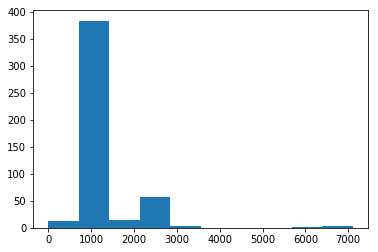

In [14]:
varmiss = df.apply(lambda x: sum(x.isna()))
plt.hist(varmiss)

Most variables have about 1000 missing values. I'll plot the sample size I can get by the number of variables (sorted by number of missing values) kept in the dataframe. 

258    2605.0
259    2586.0
260    2549.0
261    2534.0
262    2516.0
dtype: float64

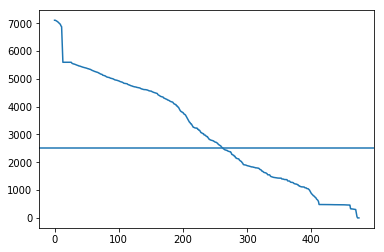

In [15]:
df = df[varmiss.sort_values().index]
sample_size = np.array([np.nan]).repeat(df.shape[1])
cum_cc = np.array([False]).repeat(df.shape[0])
for i in range(df.shape[1]):
    cum_cc = pd.DataFrame({'prev_index':cum_cc,
                           'current_index':df.iloc[:,i].isna()}).sum(axis=1)!=0
    sample_size[i] = sum(cum_cc==False)
plt.plot(sample_size)
plt.axhline(2500)
pd.Series(sample_size[sample_size>=2500]).tail()

Let's say that I want at least 500 cases in my test set, and I want my test set to be 20% of the total set. That means I'll need a total sample size of at least 2500, which means I can include 262 of my variables of interest.

In [16]:
df = df.iloc[:,:262]

Some of these variables are ordinal, some are categorical, and some appear categorical but are actually continuous. More cleaning/recoding is required. 

In [17]:
vc_list = list(np.array([np.nan]).repeat(sum(df.dtypes=='object')))
for i in range(len(vc_list)):
    valcounts = df.loc[:,pd.Series(df.dtypes=='object')].iloc[:,i].value_counts()
    onlystrs = [i for i in valcounts.index if type(i)==str]
    ordstrings = pd.Series(onlystrs).sort_values().reset_index(drop=True)
    vc_list[i] = pd.DataFrame({i:ordstrings}).transpose()

In [18]:
obvars = pd.concat(vc_list,ignore_index=True)
obvars.index = df.loc[:,pd.Series(df.dtypes=='object')].columns
obkeys = obvars.drop_duplicates().reset_index(drop=True)

In [19]:
df['A1PAGE_M2'].replace('REFUSED',np.nan,inplace=True)

In [20]:
df['A1PAGE_M2'] = df['A1PAGE_M2'].astype('float',copy=False)

In [21]:
df['female'] = [1 if i.lower()=='female' \
                else 0 if i.lower()=='male' \
                else np.nan \
                for i in df['A1PRSEX']]

In [22]:
df.drop('A1PRSEX',axis=1,inplace=True)

In [23]:
obkeys_type = ['ord', 'ord','dummy','cat/ord','ord',
               'cont','cont','cont','cat/ord','ord',
               'cat/ord','ord','cont','ord','cat/ord',
               'cat/ord','ord','cat','cat','cont','dummy']
obkeylist = [
    dict(zip(obkeys.transpose()[0][~obkeys.transpose()[0].isna()],[1,3,0,2])),
    dict(zip(obkeys.transpose()[1][~obkeys.transpose()[1].isna()],[4,1,2,0,3])),
    dict(zip(obkeys.transpose()[2][~obkeys.transpose()[2].isna()],[0,1])),
    dict(zip(obkeys.transpose()[3][~obkeys.transpose()[3].isna()],[0,1,2])),
    dict(zip(obkeys.transpose()[4][~obkeys.transpose()[4].isna()],[1,3,0,2])),
    dict(zip(obkeys.transpose()[5][~obkeys.transpose()[5].isna()],[0,10])),
    dict(zip(obkeys.transpose()[6][~obkeys.transpose()[6].isna()],[10,0])),
    dict(zip(obkeys.transpose()[7][~obkeys.transpose()[7].isna()],[0,10])),
    dict(zip(obkeys.transpose()[8][~obkeys.transpose()[8].isna()],[1,2,0])),
    dict(zip(obkeys.transpose()[9][~obkeys.transpose()[9].isna()],[0,1,2,3])),
    dict(zip(obkeys.transpose()[10][~obkeys.transpose()[10].isna()],[2,3,5,1,0,4])),
    dict(zip(obkeys.transpose()[11][~obkeys.transpose()[11].isna()],[0,3,1,2])),
    dict(zip(obkeys.transpose()[12][~obkeys.transpose()[12].isna()],[0,10])),
    dict(zip(obkeys.transpose()[13][~obkeys.transpose()[13].isna()],[1,2,3,-1,-2,-3])),
    dict(zip(obkeys.transpose()[14][~obkeys.transpose()[14].isna()],[3,6,2,4,1,0,7,5])),
    dict(zip(obkeys.transpose()[15][~obkeys.transpose()[15].isna()],[4,1,5,0,2,3])),
    dict(zip(obkeys.transpose()[16][~obkeys.transpose()[16].isna()],[4,3,0,1,2])),
    dict(zip(obkeys.transpose()[17][~obkeys.transpose()[17].isna()],
        obkeys.transpose()[17][~obkeys.transpose()[17].isna()])),
    dict(zip(obkeys.transpose()[18][~obkeys.transpose()[18].isna()],
        obkeys.transpose()[18][~obkeys.transpose()[18].isna()])),
    dict(zip(obkeys.transpose()[19][~obkeys.transpose()[19].isna()],[0])),
    dict(zip(obkeys.transpose()[20][~obkeys.transpose()[20].isna()],[0,1]))
]

In [24]:
for i in range(obvars.shape[0]):
    for j in range(len(obkeylist)):
        if obkeys.iloc[j].isin(obvars.iloc[i]).all():
            df[obvars.iloc[i].name] = df[obvars.iloc[i].name].replace(obkeylist[j])

Now let's take look at the remaining 'category' variables to make sure they're coded correctly. If they are actually continuous, recode to make them float64. If they are actually categorical, make dummy variables. First I'll check how many of the 'category' variables have numeric (i.e. int or float) observations.

In [25]:
catvars = df.dtypes[df.dtypes=='category'].index
df[catvars].apply(lambda x: sum([True if (type(i)==int or type(i)==float) and \
                                 np.isnan(i)==False else False for i in x]),
                  axis=0)

A1SJ11M      5907
A1SJ12          0
A1SJ8M       5816
A1SCVOB3     6254
A1SJ9M       5817
A1SHWEARN    6061
A1SJ10M      5737
A1SMAR       6279
A1SHHTOT     6047
A1SJ13M      5813
A1SJ13          0
SKIP_SI7        0
A1SJ12M      5974
A1SASSET     5674
dtype: int64

Now I'll put that in some context, and take a look at the value counts (non-numeric).

In [26]:
vc_list = list(np.array([np.nan]).repeat(sum(df.dtypes=='category')))
for i in range(len(vc_list)):
    valcounts = df.loc[:,pd.Series(df.dtypes=='category')].iloc[:,i].value_counts()
    onlystrs = [i for i in valcounts.index if type(i)==str]
    ordstrings = pd.Series(onlystrs).sort_values().reset_index(drop=True)
    vc_list[i] = pd.DataFrame({i:ordstrings}).transpose()
catvals = pd.concat(vc_list,ignore_index=True)
catvals

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,"$25,000 OR MORE",NOT CALCULATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,$0/NONE,$1-1000,$1000-1999,$10000-10999,$11000-11999,$12000-12999,$13000-13999,$14000-14999,$15000-15999,$16000-16999,...,$9000-9999,LESS THAN $0/LOSS,MISSING DATA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"$100,000 OR MORE",NOT CALCULATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NOT CALCULATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"$100,000 OR MORE",NOT CALCULATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Not Calculated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"$100,000 OR MORE",NOT CALCULATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NOT CALCULATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"$300,000 OR MORE",NOT CALCULATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"$100,000 OR MORE",NOT CALCULATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The 'SKIP_SI7' variable doesn't actually give us information. I'll drop it. The other two variables that don't have any numbers look like they are money related. Ordinal money-related variables are really annoying to deal with, because they often are not spaced in a way that is conducive to translating to numeric values. They also tend to have a very wide range of values. In this case, since they have quite a few missing values hidden as 'MISSING DATA' (over 1000 and 300), I'll just drop those as well. 

In [27]:
df[catvars].dtypes

A1SJ11M      category
A1SJ12       category
A1SJ8M       category
A1SCVOB3     category
A1SJ9M       category
A1SHWEARN    category
A1SJ10M      category
A1SMAR       category
A1SHHTOT     category
A1SJ13M      category
A1SJ13       category
SKIP_SI7     category
A1SJ12M      category
A1SASSET     category
dtype: object

In [28]:
catvars[[1,10,11]]

Index(['A1SJ12', 'A1SJ13', 'SKIP_SI7'], dtype='object')

In [29]:
df = df.drop(catvars[[1,10,11]],axis=1)
catvars = catvars.drop(catvars[[1,10,11]])

The rest of the 'category' variables all have "not calculated" included among otherwise-numeric data. I'll interpret 'not calculated' as missing. Depending on how many are missing, I might just drop them. 

In [30]:
df[catvars].apply(lambda x: sum([str(i).lower()=='not calculated' \
                                for i in x]),axis=0)

A1SJ11M      360
A1SJ8M       343
A1SCVOB3      71
A1SJ9M       397
A1SHWEARN    264
A1SJ10M      404
A1SMAR        46
A1SHHTOT     215
A1SJ13M      392
A1SJ12M      332
A1SASSET     651
dtype: int64

In [31]:
catvars

Index(['A1SJ11M', 'A1SJ8M', 'A1SCVOB3', 'A1SJ9M', 'A1SHWEARN', 'A1SJ10M',
       'A1SMAR', 'A1SHHTOT', 'A1SJ13M', 'A1SJ12M', 'A1SASSET'],
      dtype='object')

I know from earlier that if I lose more than 16 observations, I won't keep 500 in my test set. There are too many missing observations here, so I'll drop them.

In [32]:
df = df.drop(catvars,axis=1)

Finally, I'll make dummy variables for the remaining categorical (i.e. 'object') variables.

In [33]:
df.head()

,A1PAGE_M2,A1PD4,A1PD7,A1PD8,A1PD6,A1PD5,A1PD3,A1PD1,A1PD2,A1PD9,...,A1SK9E,A1SK12E,A1SF1O,A1SI2,A1SK11E,A1SK13C,A1SK8D,A1SF1Y,A1SF1BB,female
0,53.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,0.0,...,0,0.0,6.0,8.0,0.0,0.0,0,4.0,4.0,0.0
1,60.0,2.0,2.0,3.0,2.0,1.0,3.0,3.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,69.0,3.0,3.0,4.0,3.0,0.0,3.0,3.0,3.0,1.0,...,2,0.0,3.0,8.0,2.0,0.0,0,1.0,1.0,0.0
3,70.0,3.0,3.0,4.0,3.0,0.0,3.0,3.0,3.0,1.0,...,0,5.0,1.0,0.0,1.0,5.0,NaN,0.0,0.0,1.0
4,51.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,...,0,0.0,4.0,2.0,0.0,0.0,0,6.0,3.0,1.0


In [34]:
df = df.dropna().reset_index(drop=True)

In [35]:
df.reset_index(drop=True,inplace=True)

Make dummies for the remaining categorical variable

In [36]:
X = pd.get_dummies(df[df.dtypes[df.dtypes!='float64'].index],
              drop_first=True,
              prefix=df.dtypes[df.dtypes!='float64'].index)

In [37]:
X = pd.concat([X, df[df.dtypes[df.dtypes=='float64'].index]], axis=1)

In [38]:
X.dtypes[X.dtypes!='float64']

high_bp_1             uint8
A1SF3FF_10            uint8
A1SF3FF_NOT AT ALL    uint8
A1SF3FF_SOME          uint8
A1SF3KK_10            uint8
A1SF3KK_NOT AT ALL    uint8
A1SF3KK_SOME          uint8
A1SF4F_10             uint8
A1SF4F_NOT AT ALL     uint8
A1SF4F_SOME           uint8
A1SF3JJ_10            uint8
A1SF3JJ_NOT AT ALL    uint8
A1SF3JJ_SOME          uint8
A1SF3II_10            uint8
A1SF3II_NOT AT ALL    uint8
A1SF3II_SOME          uint8
A1SF3T_10             uint8
A1SF3T_NOT AT ALL     uint8
A1SF3T_SOME           uint8
A1SF3S_10             uint8
A1SF3S_NOT AT ALL     uint8
A1SF3S_SOME           uint8
A1SF3A_10             uint8
A1SF3A_NOT AT ALL     uint8
A1SF3A_SOME           uint8
A1SF3B_10             uint8
A1SF3B_NOT AT ALL     uint8
A1SF3B_SOME           uint8
A1SF3AA_10            uint8
A1SF3AA_NOT AT ALL    uint8
                      ...  
A1SK8D_8.0            uint8
A1SK8D_9.0            uint8
A1SK8D_10.0           uint8
A1SK8D_12.0           uint8
A1SK8D_13.0         

In [39]:
dummies = X.apply(lambda x: len(x.value_counts())==2,axis=0)
X.loc[:,~dummies]=preprocessing.scale(X.loc[:,~dummies])

In [40]:
X.columns

Index(['high_bp_1', 'A1SF3FF_10', 'A1SF3FF_NOT AT ALL', 'A1SF3FF_SOME',
       'A1SF3KK_10', 'A1SF3KK_NOT AT ALL', 'A1SF3KK_SOME', 'A1SF4F_10',
       'A1SF4F_NOT AT ALL', 'A1SF4F_SOME',
       ...
       'A1SK15G', 'A1SK12B', 'A1SK12E', 'A1SF1O', 'A1SI2', 'A1SK11E',
       'A1SK13C', 'A1SF1Y', 'A1SF1BB', 'female'],
      dtype='object', length=715)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X.drop('high_bp_1',axis=1), 
                                                    X['high_bp_1'], 
                                                    test_size = 0.20)
print([len(x_train),len(x_test)])

[2027, 507]


# Train SVM

Now I'll train the SVM model. I'll do this with a linear kernel first, so that I can get a sense of which variables are actually important (this is not possible if you use a Gaussian kernel). I'll also experiment with different C parameter values (this determines the amount of regularization) to avoid over- or under-fitting. 

In [42]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.svm import SVC

In [43]:
def pos_recall(y_true, y_pred):
    ty1 = [True if i==1 else False for i in y_true]
    out = sum(np.equal(np.array(y_pred)[ty1],np.array(y_true)[ty1]))/sum(ty1)
    return out

def pos_f1(y_true, y_pred):
    ty1 = [True if i==1 else False for i in y_true]
    tp1 = [True if i==1 else False for i in y_pred]
    rec = sum(np.equal(np.array(y_pred)[ty1],np.array(y_true)[ty1]))/sum(ty1)
    if sum(tp1)==0:
        prec=0
    else:
        prec = sum(np.equal(np.array(y_true)[tp1],np.array(y_pred)[tp1]))/sum(tp1)
    if rec+prec == 0:
        out = 0
    else:
        out = 2*((rec*prec)/(rec+prec))
    return out

In [44]:
from sklearn.model_selection import RandomizedSearchCV

In [45]:

Cs = [0.001, 0.01, 0.1, 1, 10,100]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
svm_sig = RandomizedSearchCV(svm.SVC(kernel='sigmoid'), param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5),
                              scoring=make_scorer(pos_f1))
svm_sig.fit(x_train.iloc[:,:] ,y_train[:])
svm_sig.best_params_

{'gamma': 0.001, 'C': 100}

In [46]:
mc = {}
mc['svm_sig']=pd.Series(
    confusion_matrix(y_test, svm_sig.predict(x_test)).ravel())

In [47]:
print(confusion_matrix(y_train, svm_sig.predict(x_train)))  
print(classification_report(y_train, svm_sig.predict(x_train))) 

print(confusion_matrix(y_test, svm_sig.predict(x_test)))  
print(classification_report(y_test, svm_sig.predict(x_test))) 

[[1312   25]
 [ 101   82]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1337
           1       0.77      0.45      0.57       183

   micro avg       0.92      0.92      0.92      1520
   macro avg       0.85      0.71      0.76      1520
weighted avg       0.91      0.92      0.91      1520

[[790  72]
 [133  19]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       862
           1       0.21      0.12      0.16       152

   micro avg       0.80      0.80      0.80      1014
   macro avg       0.53      0.52      0.52      1014
weighted avg       0.76      0.80      0.78      1014



In [48]:
Cs = [0.001, 0.01, 0.1, 1, 10,100]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
svm_gaus = RandomizedSearchCV(svm.SVC(kernel='rbf'), param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5),
                              scoring=make_scorer(pos_f1))
svm_gaus.fit(x_train.iloc[:,:] ,y_train[:])
svm_gaus.best_params_

{'gamma': 0.001, 'C': 10}

In [49]:
#svm_gaus = svm.SVC(kernel='rbf',C=100,gamma=.001)
#svm_gaus.fit(x_train,y_train)
mc['svm_gaus']=pd.Series(
    confusion_matrix(y_test, svm_gaus.predict(x_test)).ravel())

In [50]:
print(confusion_matrix(y_train, svm_gaus.predict(x_train)))  
print(classification_report(y_train, svm_gaus.predict(x_train))) 

print(confusion_matrix(y_test, svm_gaus.predict(x_test)))  
print(classification_report(y_test, svm_gaus.predict(x_test))) 

[[1337    0]
 [ 136   47]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1337
           1       1.00      0.26      0.41       183

   micro avg       0.91      0.91      0.91      1520
   macro avg       0.95      0.63      0.68      1520
weighted avg       0.92      0.91      0.89      1520

[[860   2]
 [152   0]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       862
           1       0.00      0.00      0.00       152

   micro avg       0.85      0.85      0.85      1014
   macro avg       0.42      0.50      0.46      1014
weighted avg       0.72      0.85      0.78      1014



In [51]:
Cs = [0.001, 0.01, 0.1, 1, 10,100]
param_grid = {'C': Cs}
svm_nokern = RandomizedSearchCV(LinearSVC(max_iter=4000),param_grid,
                         cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5),
                              scoring=make_scorer(pos_f1))
svm_nokern.fit(x_train,y_train)

/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: Convergence

RandomizedSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a25dfa470>,
          error_score='raise-deprecating',
          estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=4000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(pos_f1),
          verbose=0)

In [52]:
mc['svm_nokern']=pd.Series(
    confusion_matrix(y_test, svm_nokern.predict(x_test)).ravel())
print(confusion_matrix(y_train, svm_nokern.predict(x_train)))  
print(classification_report(y_train, svm_nokern.predict(x_train))) 

print(confusion_matrix(y_test, svm_nokern.predict(x_test)))  
print(classification_report(y_test, svm_nokern.predict(x_test))) 

[[1328    9]
 [   0  183]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1337
           1       0.95      1.00      0.98       183

   micro avg       0.99      0.99      0.99      1520
   macro avg       0.98      1.00      0.99      1520
weighted avg       0.99      0.99      0.99      1520

[[710 152]
 [108  44]]
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       862
           1       0.22      0.29      0.25       152

   micro avg       0.74      0.74      0.74      1014
   macro avg       0.55      0.56      0.55      1014
weighted avg       0.77      0.74      0.76      1014



# Compare to Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegressionCV

In [54]:
lr = LogisticRegressionCV(scoring=make_scorer(pos_recall),max_iter=1000,Cs=20)

In [55]:
lr.fit(x_train,y_train)

/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=20, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=make_scorer(pos_recall),
           solver='lbfgs', tol=0.0001, verbose=0)

In [56]:
lr.C_

array([1438.44988829])

In [57]:
mc['lr']=pd.Series(
    confusion_matrix(y_test, lr.predict(x_test)).ravel())
print(confusion_matrix(y_train, lr.predict(x_train)))  
print(classification_report(y_train, lr.predict(x_train))) 

print(confusion_matrix(y_test, lr.predict(x_test)))  
print(classification_report(y_test, lr.predict(x_test))) 

[[1337    0]
 [   0  183]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1337
           1       1.00      1.00      1.00       183

   micro avg       1.00      1.00      1.00      1520
   macro avg       1.00      1.00      1.00      1520
weighted avg       1.00      1.00      1.00      1520

[[718 144]
 [112  40]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       862
           1       0.22      0.26      0.24       152

   micro avg       0.75      0.75      0.75      1014
   macro avg       0.54      0.55      0.54      1014
weighted avg       0.77      0.75      0.76      1014



# XGBOOST

In [58]:
from xgboost import XGBClassifier

In [59]:
combs = pd.DataFrame([(d,w,g,n) \
 for d in range(3,9) \
for w in [1,2,5,10,20] \
for g in [.01,.1,1,10,100] \
for n in [10,50,100,1000]])
combs.columns = ['max_depth', 'min_child_weight',
                'gamma', 'n_estimators']

In [60]:
params = {'max_depth':list(range(3,9)),
         'min_child_weight':[1,2,5,10,20],
         'gamma':[.01,.1,1,10,100],
         'n_estimators':[10,50,100,1000]}
xgb = RandomizedSearchCV(XGBClassifier(),params,
                  cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
                              scoring=make_scorer(pos_f1))
xgb.fit(x_train.iloc[:,:], y_train[:])

RandomizedSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a23a38d30>,
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': [3, 4, 5, 6, 7, 8], 'min_child_weight': [1, 2, 5, 10, 20], 'gamma': [0.01, 0.1, 1, 10, 100], 'n_estimators': [10, 50, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(pos_f1),
          verbose=0)

In [61]:
mc['xgb']=pd.Series(
    confusion_matrix(y_test, xgb.predict(x_test)).ravel())
print(confusion_matrix(y_train, xgb.predict(x_train)))  
print(classification_report(y_train, xgb.predict(x_train))) 

print(confusion_matrix(y_test, xgb.predict(x_test)))  
print(classification_report(y_test, xgb.predict(x_test))) 

[[1337    0]
 [  50  133]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1337
           1       1.00      0.73      0.84       183

   micro avg       0.97      0.97      0.97      1520
   macro avg       0.98      0.86      0.91      1520
weighted avg       0.97      0.97      0.96      1520

[[861   1]
 [152   0]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       862
           1       0.00      0.00      0.00       152

   micro avg       0.85      0.85      0.85      1014
   macro avg       0.42      0.50      0.46      1014
weighted avg       0.72      0.85      0.78      1014



In [62]:
tvx, x_test1, tvy, y_test1 = train_test_split(X.drop('high_bp_1',axis=1), 
                                                    X['high_bp_1'], 
                                                    test_size = 0.25)
tx, vx, ty, vy = train_test_split(tvx, tvy,test_size = 0.33333)

In [63]:
xgb = XGBClassifier()

In [64]:
eval_metric = ["auc","error"]

In [65]:
xgb.fit(tx,ty,eval_set=[(vx,vy)],eval_metric=eval_metric,early_stopping_rounds=10)

[0]	validation_0-auc:0.549626	validation_0-error:0.119874
Multiple eval metrics have been passed: 'validation_0-error' will be used for early stopping.

Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-auc:0.572587	validation_0-error:0.116719
[2]	validation_0-auc:0.5809	validation_0-error:0.118297
[3]	validation_0-auc:0.578511	validation_0-error:0.118297
[4]	validation_0-auc:0.58388	validation_0-error:0.116719
[5]	validation_0-auc:0.609049	validation_0-error:0.116719
[6]	validation_0-auc:0.618074	validation_0-error:0.116719
[7]	validation_0-auc:0.62319	validation_0-error:0.115142
[8]	validation_0-auc:0.625688	validation_0-error:0.115142
[9]	validation_0-auc:0.634713	validation_0-error:0.115142
[10]	validation_0-auc:0.629139	validation_0-error:0.115142
[11]	validation_0-auc:0.651038	validation_0-error:0.115142
[12]	validation_0-auc:0.640999	validation_0-error:0.115142
[13]	validation_0-auc:0.647092	validation_0-error:0.115142
[14]	validation_0-auc:0.647

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [66]:
print(mc['svm_sig'])

0    790
1     72
2    133
3     19
dtype: int64


In [67]:
x_train.shape[1]

714

In [68]:
import tensorflow as tf

In [69]:
model = tf.keras.models.Sequential()

In [70]:
model.add(tf.keras.layers.Dense(100,activation=tf.nn.relu,
                                input_dim=x_train.shape[1]))
model.add(tf.keras.layers.Dense(100,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1,activation=tf.nn.sigmoid))

Instructions for updating:
Colocations handled automatically by placer.


In [71]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [72]:
model.fit(x_train.values,y_train.values,epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1520/1520 [==============================] - 1s 341us/sample - loss: 0.4146 - acc: 0.8566
Epoch 2/10
1520/1520 [==============================] - 0s 123us/sample - loss: 0.3254 - acc: 0.8803
Epoch 3/10
1520/1520 [==============================] - 0s 100us/sample - loss: 0.2789 - acc: 0.8842
Epoch 4/10
1520/1520 [==============================] - 0s 98us/sample - loss: 0.2189 - acc: 0.9046
Epoch 5/10
1520/1520 [==============================] - 0s 93us/sample - loss: 0.1447 - acc: 0.9454
Epoch 6/10
1520/1520 [==============================] - 0s 99us/sample - loss: 0.0753 - acc: 0.9822
Epoch 7/10
1520/1520 [==============================] - 0s 103us/sample - loss: 0.0303 - acc: 0.9980
Epoch 8/10
1520/1520 [==============================] - 0s 94us/sample - loss: 0.0124 - acc: 0.9993
Epoch 9/10
1520/1520 [==============================] - 0s 98us/sample - loss: 0.0051 - acc: 1.0000
Epoch 10/10
1520/1520 [=========================

In [73]:
model.predict(x_test)>.5

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [74]:
thresh = .001
print(confusion_matrix(y_train, 
                      [1 if i>thresh else 0 for i in model.predict(x_train)]))  
print(classification_report(y_train, 
                           [1 if i>thresh else 0 for i in model.predict(x_train)])) 

print(confusion_matrix(y_test, 
                      [1 if i>thresh else 0 for i in model.predict(x_test)]) ) 
print(classification_report(y_test, 
                            [1 if i>thresh else 0 for i in model.predict(x_test)])) 

[[983 354]
 [  0 183]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      1337
           1       0.34      1.00      0.51       183

   micro avg       0.77      0.77      0.77      1520
   macro avg       0.67      0.87      0.68      1520
weighted avg       0.92      0.77      0.81      1520

[[465 397]
 [ 78  74]]
              precision    recall  f1-score   support

           0       0.86      0.54      0.66       862
           1       0.16      0.49      0.24       152

   micro avg       0.53      0.53      0.53      1014
   macro avg       0.51      0.51      0.45      1014
weighted avg       0.75      0.53      0.60      1014



In [75]:
[1 if i>.5 else 0 for i in model.predict(x_test)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
def pos_f1_1(y_pred, y_true):
    y_true = [1 if i>.5 else 0 for i in y_true.get_label()]
    y_pred = [1 if i>.5 else 0 for i in y_pred]
    ty1 = [True if i==1 else False for i in y_true]
    tp1 = [True if i==1 else False for i in y_pred]
    rec = sum(np.equal(np.array(y_pred)[ty1],np.array(y_true)[ty1]))/sum(ty1)
    if sum(tp1)==0:
        prec=0
    else:
        prec = sum(np.equal(np.array(y_true)[tp1],np.array(y_pred)[tp1]))/sum(tp1)
    if rec+prec == 0:
        out = 0
    else:
        out = 2*((rec*prec)/(rec+prec))
    return 'f1', -1*out

In [ ]:
def misclassified(y_pred, y_true):
    """
    custom evaluation metric for xgboost, the metric
    counts the number of misclassified examples assuming 
    that classes with p>0.5 are positive
    """
    labels = y_true.get_label() # obtain true labels
    preds = y_pred > 0.5 # obtain predicted values
    return 'misclassified', np.sum(labels != preds)

In [ ]:
def pos_recall(y_pred, y_true):
    y_true = y_true.get_label()
    ty1 = [True if i>.5 else False for i in y_true]
    out = sum(np.equal(np.array(y_pred)[ty1],np.array(y_true)[ty1]))/sum(ty1)
    return 'pr', 1-out

In [ ]:
def pos_recall(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = [1 if i >.5 else 0 for i in y_pred]
    ty1 = [True if i==1 else False for i in y_true]
    out = sum(np.equal(np.array(y_pred)[ty1],np.array(y_true)[ty1]))/sum(ty1)
    return 'pr', 1-out

# ANN

In [42]:
import dlib
from PIL import Image
from skimage import io
import cv2
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import pandas as pd
import keras
from keras import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

Using TensorFlow backend.


In [43]:
sum(y_train)

273

In [44]:
y_train.reset_index(drop=True,inplace=True)

In [45]:
x_train.reset_index(drop=True,inplace=True)

In [46]:
rs1 = np.random.choice(x_train[y_train==0].index,sum(y_train),replace=False)

In [47]:
x1 = np.array(x_train[y_train==1].index)
x1

array([  11,   13,   19,   20,   38,   45,   70,   72,   77,   78,   80,
         81,   89,   94,   96,  101,  102,  112,  116,  125,  129,  130,
        131,  132,  141,  145,  149,  152,  157,  172,  173,  182,  184,
        185,  189,  193,  199,  212,  218,  222,  229,  231,  238,  242,
        248,  251,  255,  273,  280,  290,  303,  304,  307,  319,  322,
        330,  331,  337,  346,  348,  349,  376,  381,  385,  390,  395,
        409,  413,  414,  417,  436,  442,  454,  470,  472,  479,  496,
        498,  501,  524,  529,  534,  554,  557,  565,  569,  575,  577,
        583,  586,  595,  604,  615,  616,  618,  629,  630,  638,  641,
        653,  656,  658,  666,  675,  679,  687,  688,  689,  694,  711,
        712,  715,  721,  730,  737,  739,  745,  748,  749,  751,  768,
        790,  795,  803,  814,  816,  831,  833,  839,  853,  862,  871,
        887,  894,  905,  907,  912,  917,  936,  942,  947,  951,  983,
        987,  988,  991,  995, 1018, 1021, 1022, 10

In [48]:
x_ind = np.concatenate((rs1,x1))

In [49]:
np.random.shuffle(x_ind)

In [50]:
yt = np.array(y_train)[x_ind]

In [51]:
xt = np.array(x_train)[x_ind]

In [52]:
hbp_array = keras.utils.to_categorical(yt)

In [53]:

xt0 = np.array(x_train[y_train==0].sample(sum(y_train))).reshape(sum(y_train),
                                                           x_train.shape[1])

In [54]:
xt.shape

(546, 714)

In [55]:
optim = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.00001, 
                             nesterov=False)

Instructions for updating:
Colocations handled automatically by placer.


In [85]:
model = Sequential()

model.add(Dense(1000,activation='relu', input_shape=(20,)))
model.add(Dense(2000,activation='relu'))
model.add(Dense(2000,activation='relu'))
model.add(Dropout(.5,seed=1234))
model.add(Dense(1000,activation='relu'))
model.add(Dense(100,activation='relu'))

model.add(Dense(2,activation='softmax'))

In [86]:
model.compile(optim,loss='binary_crossentropy',metrics=['accuracy'])

In [141]:
npred = 20
bad_ac = 0
loop=0

model = Sequential()

model.add(Dense(npred,activation='relu', input_shape=(npred,)))
model.add(Dense(npred*2,activation='relu'))
model.add(Dropout(.5,seed=1234))
model.add(Dense(npred*3,activation='relu'))
model.add(Dense(npred*2,activation='relu'))
model.add(Dense(npred,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optim,loss='binary_crossentropy',metrics=['accuracy'])
backm = model
while bad_ac==0:
    loop = loop +1
    model = backm
    
    
    loopx = xt[:,np.random.choice(range(xt.shape[1]),npred,replace=False)]
    history = model.fit(loopx,hbp_array,epochs=10,validation_split=.2,
                        verbose=0)
    bad_ac = sum([True if i > .65 else False for i in history.history['val_acc']])
    print('finished loop '+str(loop))
    

finished loop 1
finished loop 2
finished loop 3
finished loop 4
finished loop 5
finished loop 6
finished loop 7
finished loop 8
finished loop 9
finished loop 10
finished loop 11
finished loop 12
finished loop 13
finished loop 14
finished loop 15
finished loop 16
finished loop 17
finished loop 18
finished loop 19
finished loop 20
finished loop 21
finished loop 22
finished loop 23
finished loop 24
finished loop 25
finished loop 26
finished loop 27
finished loop 28
finished loop 29
finished loop 30
finished loop 31
finished loop 32
finished loop 33
finished loop 34
finished loop 35
finished loop 36
finished loop 37
finished loop 38
finished loop 39
finished loop 40
finished loop 41
finished loop 42
finished loop 43
finished loop 44
finished loop 45
finished loop 46
finished loop 47
finished loop 48
finished loop 49
finished loop 50
finished loop 51
finished loop 52
finished loop 53
finished loop 54
finished loop 55
finished loop 56
finished loop 57
finished loop 58
finished loop 59
finish

KeyboardInterrupt: 

In [161]:
npred = sum(hc)
model = Sequential()

model.add(Dense(npred,activation='relu', input_shape=(npred,)))
model.add(Dense(npred*2,activation='relu'))
model.add(Dropout(.5,seed=1234))
model.add(Dense(npred*3,activation='relu'))
model.add(Dense(npred*2,activation='relu'))
model.add(Dense(npred,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optim,loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(xt[:,hc],
                    hbp_array,epochs=50,
                    validation_split=.2,
                    verbose=1)

Train on 436 samples, validate on 110 samples
Epoch 1/50
436/436 [==============================] - 9s 21ms/step - loss: 0.6928 - acc: 0.5252 - val_loss: 0.6683 - val_acc: 0.5818
Epoch 2/50
436/436 [==============================] - 0s 454us/step - loss: 0.6666 - acc: 0.5505 - val_loss: 0.6599 - val_acc: 0.6182
Epoch 3/50
436/436 [==============================] - 0s 437us/step - loss: 0.5974 - acc: 0.6812 - val_loss: 0.6869 - val_acc: 0.6455
Epoch 4/50
436/436 [==============================] - 0s 482us/step - loss: 0.5659 - acc: 0.7087 - val_loss: 0.6897 - val_acc: 0.5727
Epoch 5/50
436/436 [==============================] - 0s 365us/step - loss: 0.4670 - acc: 0.7959 - val_loss: 0.9723 - val_acc: 0.5727
Epoch 6/50
436/436 [==============================] - 0s 434us/step - loss: 0.4181 - acc: 0.8073 - val_loss: 1.3564 - val_acc: 0.5636
Epoch 7/50
436/436 [==============================] - 0s 424us/step - loss: 0.3433 - acc: 0.8417 - val_loss: 1.0229 - val_acc: 0.5636
Epoch 8/50
436/43

In [217]:
lxt = xt[:,si[huh[si]>.05]]
for i in np.arange(1,lxt.shape[1]):
    npred=i
    model = Sequential()

    model.add(Dense(npred,activation='relu', input_shape=(i,)))
    model.add(Dense(npred*2,activation='relu'))
    model.add(Dropout(.5,seed=1234))
    model.add(Dense(npred*3,activation='relu'))
    model.add(Dense(npred*2,activation='relu'))
    model.add(Dense(npred,activation='relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(optim,loss='binary_crossentropy',metrics=['accuracy'])

    history = model.fit(lxt[:,:i],
                        hbp_array,epochs=20,
                        validation_split=.2,
                        verbose=0)
    print('Predictors '+str(i),
          max(history.history['acc']),
          max(history.history['val_acc']))
    

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


Predictors 1 0.5091743113797739 0.5000000010837208
Predictors 2 0.5848623853211009 0.5909090909090909
Predictors 3 0.6330275234826114 0.6363636374473571
Predictors 4 0.5825688084331128 0.581818180734461
Predictors 5 0.6192660561395348 0.6000000032511624
Predictors 6 0.6261467889908257 0.6545454556291753
Predictors 7 0.6766055034934928 0.6909090898253701
Predictors 8 0.6674311915668872 0.7000000032511624
Predictors 9 0.692660549911884 0.6454545443708246
Predictors 10 0.711009173765095 0.6090909123420716
Predictors 11 0.6972477058751867 0.6545454567128962
Predictors 12 0.6926605510055472 0.6363636396147988
Predictors 13 0.711009173765095 0.654545457796617
Predictors 14 0.6857798170605931 0.6272727305238898
Predictors 15 0.6857798176074247 0.6272727305238898
Predictors 16 0.7224770636733518 0.5818181850693442
Predictors 17 0.7201834873321953 0.6454545487057078
Predictors 18 0.7408256875265629 0.6636363625526428
Predictors 19 0.7362385321100917 0.6181818214329806
Predictors 20 0.7385321106

KeyboardInterrupt: 

In [275]:
lxt = xt[:,si[huh[si]>.05]]
npred=25
model = Sequential()

model = Sequential()

model.add(Dense(npred,activation='relu', input_shape=(npred,)))
model.add(Dense(int(npred*1.5),activation='relu'))
model.add(Dropout(.5,seed=1234))
model.add(Dense(int(npred*2),activation='relu'))
model.add(Dropout(.5,seed=1234))
model.add(Dense(int(npred*2),activation='relu'))
model.add(Dropout(.5,seed=1234))
model.add(Dense(int(npred*1.5),activation='relu'))
model.add(Dense(npred,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optim,loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(lxt[:,:npred],
                        hbp_array,epochs=10,
                        validation_split=.2,
                        verbose=1)

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


Train on 436 samples, validate on 110 samples
Epoch 1/10
436/436 [==============================] - 15s 35ms/step - loss: 0.6937 - acc: 0.5092 - val_loss: 0.6986 - val_acc: 0.5000
Epoch 2/10
436/436 [==============================] - 0s 446us/step - loss: 0.6985 - acc: 0.5665 - val_loss: 0.6965 - val_acc: 0.5000
Epoch 3/10
436/436 [==============================] - 0s 438us/step - loss: 0.6797 - acc: 0.5665 - val_loss: 0.6794 - val_acc: 0.5727
Epoch 4/10
436/436 [==============================] - 0s 391us/step - loss: 0.6790 - acc: 0.5780 - val_loss: 0.6882 - val_acc: 0.5091
Epoch 5/10
436/436 [==============================] - 0s 318us/step - loss: 0.6733 - acc: 0.5963 - val_loss: 0.7101 - val_acc: 0.5091
Epoch 6/10
436/436 [==============================] - 0s 447us/step - loss: 0.6659 - acc: 0.5963 - val_loss: 0.6888 - val_acc: 0.5273
Epoch 7/10
436/436 [==============================] - 0s 444us/step - loss: 0.6546 - acc: 0.6514 - val_loss: 0.6916 - val_acc: 0.5364
Epoch 8/10
436/4

In [ ]:
lxtest = xt[:,si[huh[si]>.05]]

In [239]:
model.predict(np.array(x_test)[:,si[huh[si]>.05]][:,:25])

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([[1.4395447e-02, 9.8560452e-01],
       [2.2532420e-05, 9.9997747e-01],
       [5.3453153e-01, 4.6546841e-01],
       ...,
       [9.7541410e-01, 2.4585905e-02],
       [9.5666796e-01, 4.3332022e-02],
       [3.4323926e-05, 9.9996567e-01]], dtype=float32)

In [242]:
model.predict_classes(lxt[:,:npred])
model.predict_classes(lxt[:,:npred])

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,

In [243]:
from sklearn.metrics import confusion_matrix

In [276]:
confusion_matrix(y_test,
                 model.predict_classes(np.array(x_test)[:,si[huh[si]>.05]][:,:25]))

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


array([[356,  89],
       [ 42,  20]])

In [292]:
print(confusion_matrix(y_test,
                  np.array([i[1] for i in\
                               model.predict(np.array(x_test\
                                            )[:,si[huh[si]>.05]][:,:25])])>.4
                      ))
print(classification_report(y_test, 
                     np.array([i[1] for i in\
                               model.predict(np.array(x_test\
                                            )[:,si[huh[si]>.05]][:,:25])])>.4
                           ))

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


[[169 276]
 [ 14  48]]
              precision    recall  f1-score   support

           0       0.92      0.38      0.54       445
           1       0.15      0.77      0.25        62

   micro avg       0.43      0.43      0.43       507
   macro avg       0.54      0.58      0.39       507
weighted avg       0.83      0.43      0.50       507



In [260]:
np.array([i[1] for i in model.predict(np.array(x_test)[:,si[huh[si]>.05]][:,:25])])>.4


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([ True,  True,  True, False, False, False,  True,  True, False,
        True, False,  True, False,  True, False, False,  True,  True,
       False, False, False, False, False, False, False,  True, False,
        True,  True, False, False, False, False,  True, False,  True,
        True,  True,  True, False, False,  True, False,  True, False,
       False,  True, False, False,  True, False, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True, False,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True, False, False,
        True, False,  True,  True, False,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True, False, False,  True, False,  True,  True, False, False,
        True, False, False, False, False, False, False,  True, False,
        True, False, False,  True,  True,  True, False,  True, False,
        True,  True,

In [261]:
si[huh[si]>.05]

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([600, 191, 680, 455, 667, 121, 605, 125, 614, 570, 608, 699, 156,
       703,  76, 252, 641,  40, 214, 102, 508,  36,  28, 461, 624, 216,
       222,  19, 181, 179, 713, 108, 113, 422, 266, 712, 623, 645, 630,
       656, 532, 437, 143,  37, 104, 308, 629, 606, 219, 116, 134, 377,
        20,  62, 237, 381, 676,  49,  14, 615, 223,  11, 107, 613, 653,
       710,  69, 210, 626, 136,  12,  77, 215, 411, 590, 132, 281,  96,
        95, 602,   9, 545, 129, 239, 697, 255, 180, 414, 652, 112, 193,
        50, 140, 154, 204, 464, 339, 604, 672, 155, 647, 704, 607, 370,
        86,  39, 176, 379, 245, 671, 202, 421, 198, 144,  70, 566,   1,
       261, 192, 640, 523, 334, 525, 575, 273, 292, 579, 497, 449, 501,
       272, 285, 644, 188, 625, 435, 372,  99, 693, 679,  59, 382, 329,
       635, 392, 567,  15, 408, 670, 123, 550, 325, 668, 322, 419, 665,
        88,  16, 244, 122, 120, 360, 349, 170, 342, 340,  58, 695, 311,
       638, 110, 128, 694, 469,  74, 393,  24, 688, 378,  29,   

In [191]:
huh = np.abs([np.corrcoef(xt[:,i],yt)[0][1] for i in range(xt.shape[1])])

In [192]:
si = huh.argsort()[::-1]

In [210]:
huh[si[huh[si]>.05]]
si[huh[si]>.05]

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


array([600, 191, 680, 455, 667, 121, 605, 125, 614, 570, 608, 699, 156,
       703,  76, 252, 641,  40, 214, 102, 508,  36,  28, 461, 624, 216,
       222,  19, 181, 179, 713, 108, 113, 422, 266, 712, 623, 645, 630,
       656, 532, 437, 143,  37, 104, 308, 629, 606, 219, 116, 134, 377,
        20,  62, 237, 381, 676,  49,  14, 615, 223,  11, 107, 613, 653,
       710,  69, 210, 626, 136,  12,  77, 215, 411, 590, 132, 281,  96,
        95, 602,   9, 545, 129, 239, 697, 255, 180, 414, 652, 112, 193,
        50, 140, 154, 204, 464, 339, 604, 672, 155, 647, 704, 607, 370,
        86,  39, 176, 379, 245, 671, 202, 421, 198, 144,  70, 566,   1,
       261, 192, 640, 523, 334, 525, 575, 273, 292, 579, 497, 449, 501,
       272, 285, 644, 188, 625, 435, 372,  99, 693, 679,  59, 382, 329,
       635, 392, 567,  15, 408, 670, 123, 550, 325, 668, 322, 419, 665,
        88,  16, 244, 122, 120, 360, 349, 170, 342, 340,  58, 695, 311,
       638, 110, 128, 694, 469,  74, 393,  24, 688, 378,  29,   

In [196]:
np.isnan(np.abs([np.corrcoef(xt[:,i],yt)[0][1] for i in range(xt.shape[1])]))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,